In [13]:
from importlib import reload
import model_functions
reload(model_functions)
from model_functions import plot_ground_heigth, plot_alpha_scores, fit_model_with_files, load_and_prepare_data, calculate_maneuver_recall
import file_functions
reload(file_functions)
from file_functions import get_filepaths_in_folder_with_ending
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# 1. Visualize preprocessed flight data

In [2]:
data_dir = "train_data"
flight_id = '08412468-26ac-4777-9afb-4671f426277b'

parquet_path = os.path.join('..', 'data_process', data_dir, f"{flight_id}.parquet")

df = pd.read_parquet(parquet_path)

#df.info()
print(df.head())

                                                6417134  28827303  45268905  \
TimeStamp                        FrameCounter                                 
2024-02-14 06:46:58.397576+00:00 0             0.457152       0.0       0.0   
2024-02-14 06:46:58.416348+00:00 1             0.457152       0.0       0.0   
2024-02-14 06:47:00.886922+00:00 2             0.457152       0.0       0.0   
2024-02-14 06:47:00.894921+00:00 3             0.457152       0.0       0.0   
2024-02-14 06:47:00.926924+00:00 4             0.457152       0.0       0.0   

                                               108790465  117182271  \
TimeStamp                        FrameCounter                         
2024-02-14 06:46:58.397576+00:00 0                  75.0   2.312171   
2024-02-14 06:46:58.416348+00:00 1                  75.0   2.312171   
2024-02-14 06:47:00.886922+00:00 2                  75.0   2.309550   
2024-02-14 06:47:00.894921+00:00 3                  75.0   2.309550   
2024-02-14 06:47:00.

In [3]:
print(df.columns)
print(df.index)

Index(['6417134', '28827303', '45268905', '108790465', '117182271',
       '156751662', '156875280', '192589766', '203733126', '301190512',
       ...
       '4096114806', '4096188490', '4174711423', '4210968644', '4211937095',
       '4233706951', '4247030081', '4264003232', '4294814812', 'Label'],
      dtype='object', length=190)
MultiIndex([('2024-02-14 06:46:58.397576+00:00',      0),
            ('2024-02-14 06:46:58.416348+00:00',      1),
            ('2024-02-14 06:47:00.886922+00:00',      2),
            ('2024-02-14 06:47:00.894921+00:00',      3),
            ('2024-02-14 06:47:00.926924+00:00',      4),
            ('2024-02-14 06:47:00.946964+00:00',      5),
            ('2024-02-14 06:47:00.950532+00:00',      6),
            ('2024-02-14 06:47:00.961775+00:00',      7),
            ('2024-02-14 06:47:00.978790+00:00',      8),
            ('2024-02-14 06:47:00.984390+00:00',      9),
            ...
            ('2024-02-14 07:03:21.102460+00:00', 253960),
           

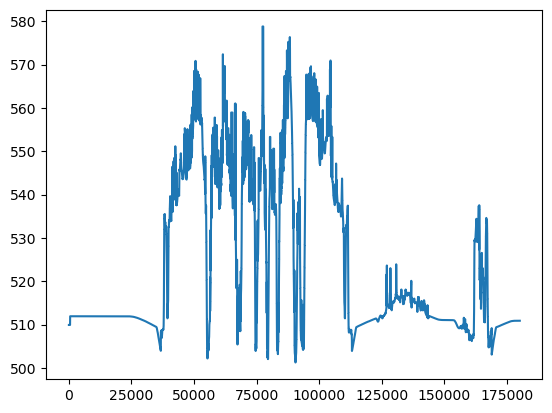

In [4]:
plot_ground_heigth(df)

# 2. Read Label from preprocessed data

In [27]:
data_dir = "train_data"
flight_id = '0bbf0c4e-fb3c-4213-bff8-ef21ee5ebf79'
data_dir_path = os.path.join('..', 'data_process', data_dir)
parquet_path = os.path.join(data_dir_path, f"{flight_id}.parquet")
df = pd.read_parquet(parquet_path)

label_path = os.path.join(data_dir_path, f"{flight_id}.csv")
labels = pd.read_csv(label_path)
maneuvers = np.unique(labels["maneuver"])

print(maneuvers)
print(df['Label'])


['Climb' 'Descent' 'Hover' 'Left Turn' 'No Maneuver' 'Right Turn'
 'Straight and Level']
TimeStamp                         FrameCounter
2024-02-15 08:12:07.277872+00:00  0               no maneuver
2024-02-15 08:12:07.289546+00:00  1               no maneuver
2024-02-15 08:12:09.829034+00:00  2               no maneuver
2024-02-15 08:12:09.838211+00:00  3               no maneuver
2024-02-15 08:12:09.867992+00:00  4               no maneuver
                                                     ...     
2024-02-15 08:28:40.140542+00:00  259788          no maneuver
2024-02-15 08:28:40.151965+00:00  259789          no maneuver
2024-02-15 08:28:40.161623+00:00  259790          no maneuver
2024-02-15 08:28:40.173315+00:00  259791          no maneuver
2024-02-15 08:28:40.185377+00:00  259792          no maneuver
Name: Label, Length: 189764, dtype: object


In [29]:
print(df.head())

                                                6417134  28827303  45268905  \
TimeStamp                        FrameCounter                                 
2024-02-15 08:12:07.277872+00:00 0             0.465298       0.0       0.0   
2024-02-15 08:12:07.289546+00:00 1             0.465298       0.0       0.0   
2024-02-15 08:12:09.829034+00:00 2             0.465298       0.0       0.0   
2024-02-15 08:12:09.838211+00:00 3             0.465298       0.0       0.0   
2024-02-15 08:12:09.867992+00:00 4             0.465298       0.0       0.0   

                                               108790465  117182271  \
TimeStamp                        FrameCounter                         
2024-02-15 08:12:07.277872+00:00 0                  75.0   1.567354   
2024-02-15 08:12:07.289546+00:00 1                  75.0   1.567354   
2024-02-15 08:12:09.829034+00:00 2                  75.0   1.567354   
2024-02-15 08:12:09.838211+00:00 3                  75.0   1.567354   
2024-02-15 08:12:09.

# 3. Time-Series modifications

In [39]:
#TODO Time-Series specific data manipulation required ?

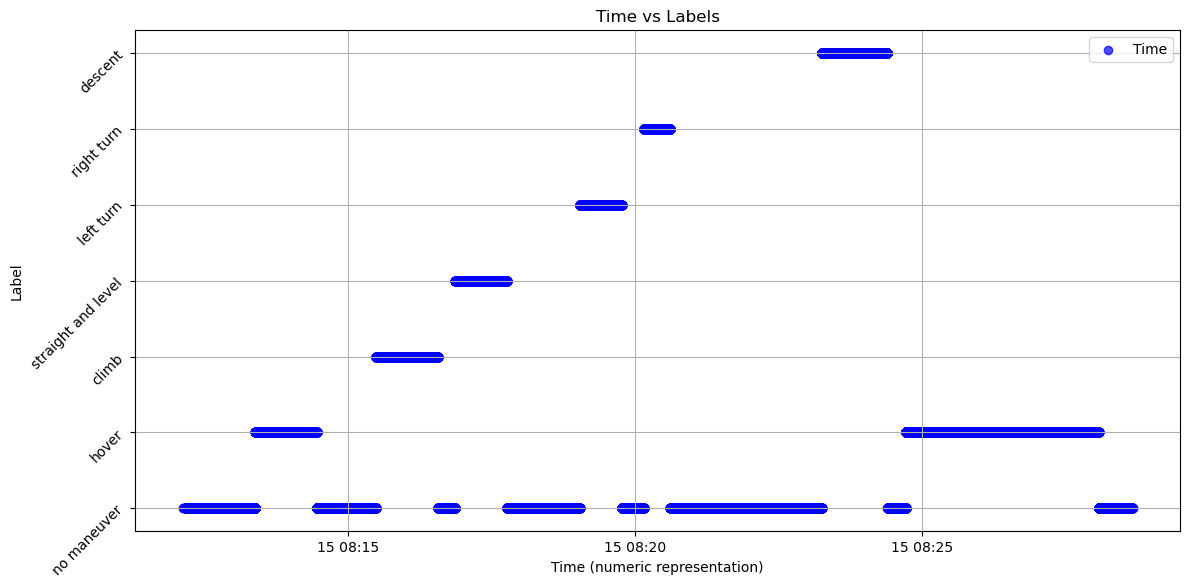

In [39]:
# Plotting start_time + end_time vs label
plt.figure(figsize=(12, 6))

# Convert start and end times to numeric for plotting
numeric_time = pd.to_datetime(df.index.get_level_values('TimeStamp'))

# Scatter plot for start and end times with labels
plt.scatter(numeric_time,df['Label'], label='Time', alpha=0.7, color='blue')

# Format plot
plt.title("Time vs Labels")
plt.xlabel("Time (numeric representation)")
plt.ylabel("Label")
plt.legend()
plt.grid()
plt.yticks(rotation=45)
plt.tight_layout()

plt.show()

In [41]:
# Load the Parquet data
file_path = '../data_process/train_data/0bbf0c4e-fb3c-4213-bff8-ef21ee5ebf79.parquet'
parquet_data = pd.read_parquet(file_path)

# Ensure TimeStamp is a datetime index for time-based operations
parquet_data.index = pd.to_datetime(parquet_data.index.get_level_values('TimeStamp'))

# Parameters for sliding window
window_size = '60s'  # 60-second time window
step_size = '30s'    # 30-second step size for sliding window


# Function to extract features from each block
def extract_features(block):
    features = {}
    for col in block.columns:
        if block[col].dtype in ['float64', 'int64']:  # Only process numeric columns
            features[f'{col}_mean'] = block[col].mean()
            features[f'{col}_std'] = block[col].std()
            features[f'{col}_max'] = block[col].max()
            features[f'{col}_min'] = block[col].min()
    # Adding block start and end timestamps for reference
    features['start_time'] = block.index[0]
    features['end_time'] = block.index[-1]
    features['most_frequent_label'] = block['Label'].mode()[0]
    return features

# Sliding window processing
blocks = []
start_time = parquet_data.index.min()

while start_time <= parquet_data.index.max():
    # Define the time window
    end_time = start_time + pd.Timedelta(window_size)
    
    # Select data within the time window
    block = parquet_data.loc[start_time:end_time]
    if not block.empty:
        blocks.append(extract_features(block))
    
    # Slide the window forward
    start_time += pd.Timedelta(step_size)


# Create a DataFrame from the extracted features
features_df = pd.DataFrame(blocks)

print(features_df.head())

   6417134_mean   6417134_std  6417134_max  6417134_min  28827303_mean  \
0      0.465298  2.614724e-14     0.465298     0.465298            0.0   
1      0.465298  1.386163e-13     0.465298     0.465298            0.0   
2      0.465298  1.761424e-13     0.465298     0.465298            0.0   
3      0.465298  1.748656e-13     0.465298     0.465298            0.0   
4      0.465298  1.348970e-13     0.465298     0.465298            0.0   

   28827303_std  28827303_max  28827303_min  45268905_mean  45268905_std  ...  \
0           0.0           0.0           0.0            0.0           0.0  ...   
1           0.0           0.0           0.0            0.0           0.0  ...   
2           0.0           0.0           0.0            0.0           0.0  ...   
3           0.0           0.0           0.0            0.0           0.0  ...   
4           0.0           0.0           0.0            0.0           0.0  ...   

   4264003232_std  4264003232_max  4264003232_min  4294814812_mean  

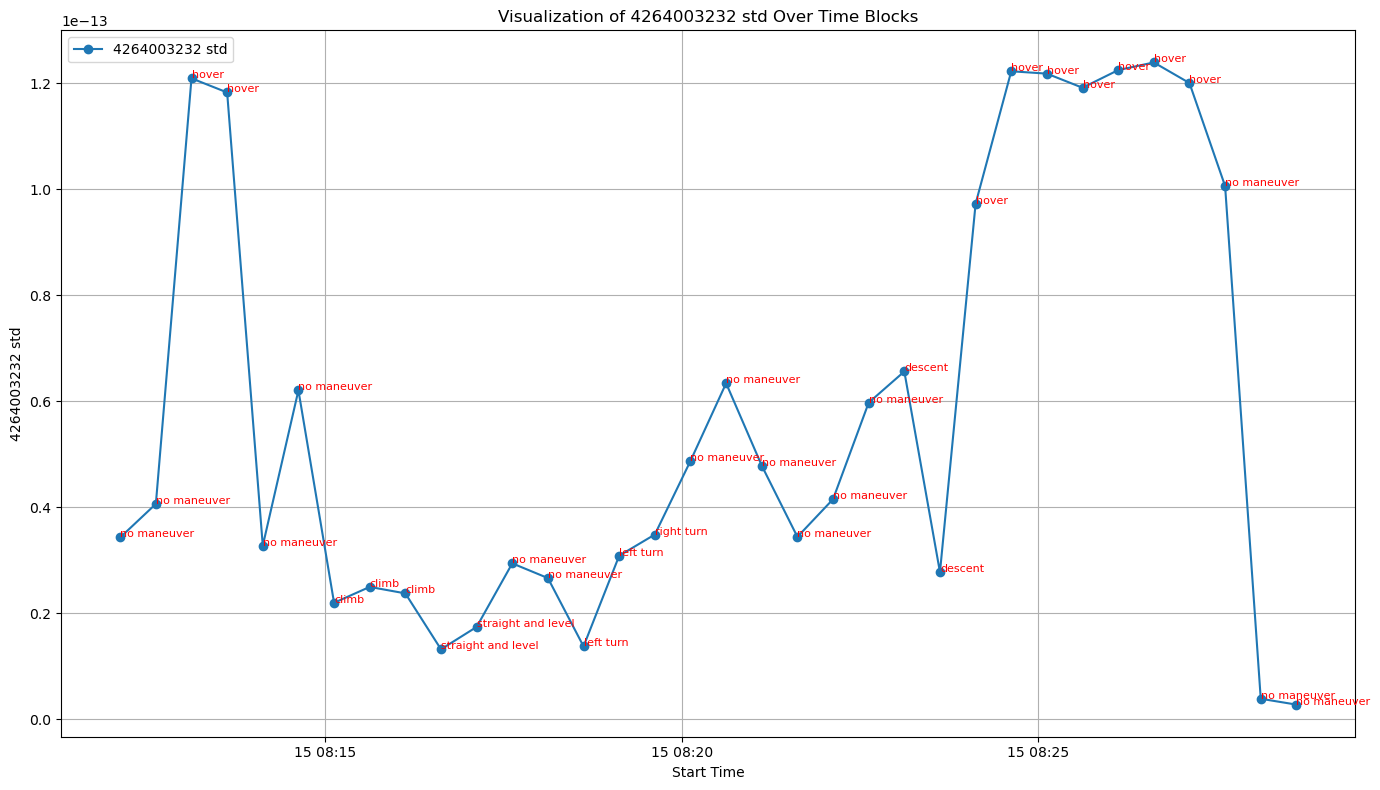

In [49]:
#example vusalization
def visualize_features_over_time(features_df, feature_prefix="4264003232"):
    plt.figure(figsize=(14, 8))

    # Extract mean values for a specific feature prefix
    mean_col = f"{feature_prefix}_std"
    if mean_col not in features_df.columns:
        print(f"Feature {mean_col} not found in DataFrame.")
        return

    # Plot mean values over time
    plt.plot(features_df['start_time'], features_df[mean_col], label=f"{feature_prefix} std", marker='o')

    # Annotate with most frequent labels
    for i, label in enumerate(features_df['most_frequent_label']):
        plt.text(features_df['start_time'][i], features_df[mean_col][i], str(label), fontsize=8, color='red')

    # Plot formatting
    plt.title(f"Visualization of {feature_prefix} std Over Time Blocks")
    plt.xlabel("Start Time")
    plt.ylabel(f"{feature_prefix} std")
    plt.grid()
    plt.legend()
    plt.tight_layout()
    plt.show()

# Visualize feature '6417134_mean'
visualize_features_over_time(features_df, feature_prefix="4264003232")

In [50]:
#Run for all files


# 4. Lasso model and k-fold cross validation

Fit a linear regression classification lasso model and find the best alpha-parameter with the k-fold cross validation.
The goal of that is to get only the few most significant features, so that we can limit our preprocessing and future models to those columns.

In [10]:
# Load blocked data for training, validation, and testing
def load_blocked_data(file_paths):
    data_frames = [pd.read_csv(file) for file in file_paths]
    return pd.concat(data_frames, ignore_index=True)

In [11]:
# Get file paths for blocked data
def get_file_paths(folder, ending='.csv'):
    return [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(ending)]

In [14]:
# File paths for training, validation, and testing
train_file_paths = get_file_paths('../data_process/processed_with_blocks/train_data')
validate_file_paths = get_file_paths('../data_process/processed_with_blocks/validate_data')
test_file_paths = get_file_paths('../data_process/processed_with_blocks/test_data')

# Load blocked data
train_data = load_blocked_data(train_file_paths)
validate_data = load_blocked_data(validate_file_paths)
test_data = load_blocked_data(test_file_paths)

# Combine training and validation data
full_train_data = pd.concat([train_data, validate_data], ignore_index=True)

# Prepare features and labels
feature_columns = [col for col in full_train_data.columns if col not in ['start_time', 'end_time', 'most_frequent_label']]
X_train = full_train_data[feature_columns]
y_train = full_train_data['most_frequent_label']

In [6]:
model_train_file_paths = train_file_paths + validate_file_paths

In [7]:
possible_maneuvers = set()
maneuver_file_paths = np.concatenate((test_file_paths, validate_file_paths, train_file_paths))

for file in maneuver_file_paths:
    labels = pd.read_csv(file)
    possible_maneuvers.update(map(str.lower, np.unique(labels["most_frequent_label"])))

print(possible_maneuvers)
possible_maneuvers = list(possible_maneuvers)

{'hover', 'straight and level', 'no maneuver', 'climb', 'descent', 'autorotation', 'left turn', 'right turn'}


Alpha: 0.01, Score: 0.39195493308525764
Alpha: 0.02, Score: 0.39195493308525764
Alpha: 0.03, Score: 0.39195493308525764
Alpha: 0.04, Score: 0.39195493308525764
Alpha: 0.05, Score: 0.39195493308525764
Alpha: 0.1, Score: 0.2485375578687563
Alpha: 1, Score: 0.39195493308525764
Alpha: 3, Score: 0.39195493308525764
Alpha: 5, Score: 0.39195493308525764
Alpha: 7, Score: 0.24759555835861793
Alpha: 10, Score: 0.053910194429842635
Alpha: 20, Score: 0.05778370039660517
Alpha: 50, Score: 0.05111808343339728
Alpha: 100, Score: 0.05111808343339728
Alpha: 200, Score: 0.05111808343339728
Alpha: 500, Score: 0.05111808343339728
Alpha: 1000, Score: 0.05111808343339728
Best Alpha: 0.01, Best CV Score: 0.39195493308525764
Alpha Scores for Current Run: [(0.01, 0.39195493308525764), (0.02, 0.39195493308525764), (0.03, 0.39195493308525764), (0.04, 0.39195493308525764), (0.05, 0.39195493308525764), (0.1, 0.2485375578687563), (1, 0.39195493308525764), (3, 0.39195493308525764), (5, 0.39195493308525764), (7, 0.24

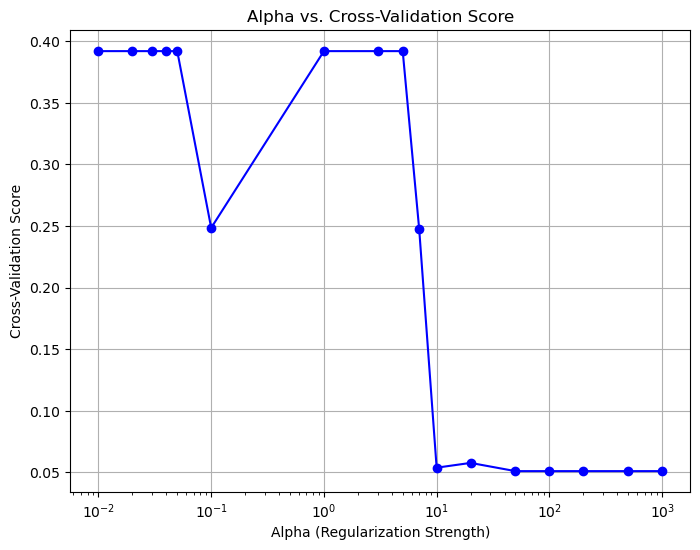

In [8]:
# Define alphas and KFold
alphas = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1, 3, 5, 7, 10, 20, 50, 100, 200, 500, 1000]
kf = KFold(n_splits=4, shuffle=True, random_state=42)  # Add random_state for consistency

best_alpha = None
best_score = -np.inf
alpha_scores = []

for alpha in alphas:
    scores = []

    for train_idx, val_idx in kf.split(model_train_file_paths):
        # Get training and validation split file paths
        train_files = [model_train_file_paths[i] for i in train_idx]
        val_files = [model_train_file_paths[i] for i in val_idx]

        # Train model
        model = SGDClassifier(loss='log_loss', penalty='l1', alpha=alpha, random_state=42)
        columns = fit_model_with_files(model, train_files, possible_maneuvers)

        # Validate model
        val_scores = []
        for file in val_files:
            X, y = load_and_prepare_data(file)
            val_scores.append(model.score(X, y))

        scores.append(np.mean(val_scores))

    # Average score for the current alpha
    mean_score = np.mean(scores)
    alpha_scores.append((alpha, mean_score))
    print(f"Alpha: {alpha}, Score: {mean_score}")

    # Update the best alpha if needed
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha

print(f"Best Alpha: {best_alpha}, Best CV Score: {best_score}")

# Debug: Print alpha scores
print("Alpha Scores for Current Run:", alpha_scores)

# Plot alpha scores
plot_alpha_scores(alpha_scores)


In [9]:
final_model = SGDClassifier(loss='log_loss', penalty='l1', alpha=best_alpha)

columns = fit_model_with_files(final_model, model_train_file_paths, possible_maneuvers)

In [123]:
coefficients = pd.DataFrame(final_model.coef_, columns=columns)

# identify unnecessary features (zero coefficients across all classes)
unnecessary_features = coefficients.columns[(coefficients == 0).all()].tolist()
print(f"Unnecessary: {len(unnecessary_features)}")

necessary_features = coefficients.columns[(coefficients != 0).any()].tolist()
print(f"Necessary: {len(necessary_features)}")
print(necessary_features)

Unnecessary: 277
Necessary: 479
['6417134_mean', '6417134_max', '6417134_min', '28827303_mean', '28827303_std', '28827303_max', '28827303_min', '108790465_mean', '108790465_max', '108790465_min', '117182271_mean', '117182271_std', '117182271_max', '117182271_min', '156751662_mean', '156751662_max', '156751662_min', '156875280_mean', '156875280_std', '156875280_max', '156875280_min', '203733126_mean', '203733126_max', '203733126_min', '301190512_mean', '301190512_std', '301190512_max', '301190512_min', '340940040_mean', '340940040_max', '340940040_min', '353872548_mean', '353872548_std', '353872548_max', '353872548_min', '362955152_mean', '362955152_max', '362955152_min', '381802901_mean', '381802901_max', '381802901_min', '419755350_mean', '419755350_std', '419755350_max', '419755350_min', '439066970_mean', '439066970_max', '439066970_min', '491152707_mean', '491152707_max', '491152707_min', '513685691_mean', '513685691_std', '513685691_max', '513685691_min', '518160218_mean', '5181602

In [125]:
# Evaluate on test data
maneuver_recalls = []
maneuver_scores = []

# Debugging predictions and recall calculation
for test_file in test_file_paths:
    X, y = load_and_prepare_data(test_file)
    preds = final_model.predict(X)

    print(f"Test File: {test_file}")
    print(f"Predicted Labels: {np.unique(preds)}")
    print(f"Ground Truth Labels: {np.unique(y)}")

    # Calculate maneuver recall and scores
    flight_id = os.path.splitext(os.path.basename(test_file))[0]
    dir_path = os.path.dirname(test_file)
    maneuver_score, maneuver_recall = calculate_maneuver_recall(dir_path, flight_id, X, preds, threshhold=0.5)

    print(f"Maneuver Score: {maneuver_score}")
    print(f"Maneuver Recall: {maneuver_recall}")

# Aggregate results
overall_recall = np.mean(maneuver_recalls)
print(f"Overall Recall: {overall_recall}")


Test File: ../data_process/processed_with_blocks/test_data\0b3f3902-2c04-4625-8576-3bb963e3d709.csv
Predicted Labels: ['descent']
Ground Truth Labels: ['autorotation' 'climb' 'descent' 'hover' 'left turn' 'no maneuver'
 'right turn']
Maneuver Score: {'autorotation': 0.0, 'climb': 0.0, 'descent': 0.0, 'hover': 0.0, 'left turn': 0.0, 'right turn': 0.0}
Maneuver Recall: 0.0
Test File: ../data_process/processed_with_blocks/test_data\663f573a-74c5-4368-b60b-1fb433cd835d.csv
Predicted Labels: ['descent']
Ground Truth Labels: ['autorotation' 'climb' 'descent' 'hover' 'left turn' 'no maneuver'
 'right turn' 'straight and level']
Maneuver Score: {'autorotation': 0.0, 'climb': 0.0, 'descent': 0.0, 'hover': 0.0, 'left turn': 0.0, 'right turn': 0.0, 'straight and level': 0.0}
Maneuver Recall: 0.0
Test File: ../data_process/processed_with_blocks/test_data\8c36586f-94e9-4ae9-8384-0f3342008677.csv
Predicted Labels: ['descent']
Ground Truth Labels: ['autorotation' 'climb' 'descent' 'hover' 'left turn'

c:\Users\zhili.zhou\loftdynamics-1\fit_model\model_functions.py:66: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  maneuvers['start_time'] = pd.to_datetime(maneuvers['start_time']).view(np.int64)  # Convert to int64
c:\Users\zhili.zhou\loftdynamics-1\fit_model\model_functions.py:67: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  maneuvers['end_time'] = pd.to_datetime(maneuvers['end_time']).view(np.int64)
c:\Users\zhili.zhou\loftdynamics-1\fit_model\model_functions.py:66: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  maneuvers['start_time'] = pd.to_datetime(maneuvers['start_time']).view(np.int64)  # Convert to int64
c:\Users\zhili.zhou\loftdynamics-1\fit_model\model_functions.py:67: FutureWarning: Series.view is depre

Overall Recall: nan


c:\Users\zhili.zhou\AppData\Local\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\zhili.zhou\AppData\Local\anaconda3\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# 5. RandomForestClassifier

In [5]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

def load_and_prepare_data(file_path):
 
    df = pd.read_csv(file_path)
    y = df['most_frequent_label']
    X = df.drop(columns=['most_frequent_label', 'start_time', 'end_time'])
    return X, y


In [6]:

rf_model = RandomForestClassifier(
    n_estimators=100,      
    max_depth=10,          
    class_weight="balanced",  
    random_state=42       
)

def train_random_forest(train_files):

    X_train, y_train = [], []
    for file in train_files:
        X, y = load_and_prepare_data(file)
        X_train.append(X)
        y_train.append(y)

    X_train = pd.concat(X_train)
    y_train = pd.concat(y_train)

    print("Training Class Distribution:", Counter(y_train)) 
    rf_model.fit(X_train, y_train)
    return rf_model

In [7]:
def validate_model(model, val_files):
    X_val, y_val = [], []
    for file in val_files:
        X, y = load_and_prepare_data(file)
        X_val.append(X)
        y_val.append(y)

    X_val = pd.concat(X_val)
    y_val = pd.concat(y_val)

    y_pred = model.predict(X_val)
    print("Validation Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))


In [27]:
def test_model(model, test_files):

    maneuver_recalls = []
    maneuver_scores = []

    for test_file in test_files:
        X, y = load_and_prepare_data(test_file)
        preds = model.predict(X)

        print(f"Test File: {test_file}")
        print("Classification Report:")
        print(classification_report(y, preds))
        print("Confusion Matrix:")
        print(confusion_matrix(y, preds))

        recall = classification_report(y, preds, output_dict=True)['weighted avg']['recall']
        maneuver_recalls.append(recall)

    overall_recall = sum(maneuver_recalls) / len(maneuver_recalls)
    print(f"Overall Recall: {overall_recall}")


In [133]:
feature_importances = rf_model.feature_importances_
sorted_importances = sorted(zip(feature_importances, X_train.columns), reverse=True)
print("Top Features:", sorted_importances[:10])


Top Features: [(0.02961872928439413, '4247030081_mean'), (0.023964954379350995, '3207956524_mean'), (0.022343506188648367, '3966668421_mean'), (0.01989811407855415, '3502630583_mean'), (0.018690222742606535, '2546226082_std'), (0.018411311955189618, '637219977_std'), (0.017643341089683892, '117182271_std'), (0.017123045309871444, '1501357761_mean'), (0.01663548027420091, '1984892607_mean'), (0.016035465302579443, '4056189073_std')]


In [137]:

rf_model = train_random_forest(train_file_paths)

validate_model(rf_model, validate_file_paths)

test_model(rf_model, test_file_paths)


Training Class Distribution: Counter({'no maneuver': 261, 'straight and level': 50, 'hover': 49, 'descent': 46, 'climb': 45, 'left turn': 35, 'autorotation': 33, 'right turn': 32})
Validation Classification Report:
                    precision    recall  f1-score   support

      autorotation       1.00      0.80      0.89         5
             climb       0.82      0.88      0.85        16
           descent       0.82      0.88      0.85        16
             hover       0.73      0.92      0.81        12
         left turn       0.56      0.45      0.50        11
       no maneuver       0.88      0.85      0.86       127
        right turn       0.78      0.70      0.74        10
straight and level       0.64      0.82      0.72        11

          accuracy                           0.83       208
         macro avg       0.78      0.79      0.78       208
      weighted avg       0.83      0.83      0.83       208

Confusion Matrix:
[[  4   0   0   0   0   1   0   0]
 [  0  14

c:\Users\zhili.zhou\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhili.zhou\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zhili.zhou\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [136]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
rf_model.fit(X_resampled, y_resampled)


validate_model(rf_model, validate_file_paths)

test_model(rf_model, test_file_paths)

Validation Classification Report:
                    precision    recall  f1-score   support

      autorotation       1.00      1.00      1.00         5
             climb       1.00      1.00      1.00        16
           descent       1.00      1.00      1.00        16
             hover       1.00      1.00      1.00        12
         left turn       1.00      1.00      1.00        11
       no maneuver       1.00      0.98      0.99       127
        right turn       0.91      1.00      0.95        10
straight and level       0.92      1.00      0.96        11

          accuracy                           0.99       208
         macro avg       0.98      1.00      0.99       208
      weighted avg       0.99      0.99      0.99       208

Confusion Matrix:
[[  5   0   0   0   0   0   0   0]
 [  0  16   0   0   0   0   0   0]
 [  0   0  16   0   0   0   0   0]
 [  0   0   0  12   0   0   0   0]
 [  0   0   0   0  11   0   0   0]
 [  0   0   0   0   0 125   1   1]
 [  0   0   0  

# 6. XGBoost

In [31]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from collections import Counter
from imblearn.over_sampling import SMOTE
import os
from sklearn.preprocessing import LabelEncoder

def train_xgboost(train_file_paths):
    train_data = load_blocked_data(train_file_paths)
    X_train = train_data[feature_columns]
    y_train = train_data['most_frequent_label']

    print("Training Class Distribution:", Counter(y_train))
    
    # Encode labels to numeric values
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    smote = SMOTE()
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
    
    xgb_model = XGBClassifier(
        n_estimators=100,   
        max_depth=10,          
        learning_rate=0.1,     
        random_state=42,
    )
    xgb_model.fit(X_train_resampled, y_train_resampled)
    xgb_model.label_encoder = label_encoder
    return xgb_model

def validate_xgb_model(model, validate_file_paths):
    validate_data = load_blocked_data(validate_file_paths)
    X_val = validate_data[feature_columns]
    y_val = validate_data['most_frequent_label']

    y_val_encoded = model.label_encoder.transform(y_val)
    y_pred_encoded = model.predict(X_val)
    y_pred = model.label_encoder.inverse_transform(y_pred_encoded)

    print("Validation Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

def test_model(model, test_file_paths):
    test_data = load_blocked_data(test_file_paths)
    X_test = test_data[feature_columns]
    y_test = test_data['most_frequent_label']

    y_test_encoded = model.label_encoder.transform(y_test)
    y_pred_encoded = model.predict(X_test)
    y_pred = model.label_encoder.inverse_transform(y_pred_encoded)

    print("Test Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    recall = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall']
    print(f"Overall Test Recall: {recall}")




In [24]:
xgb_model = train_xgboost(train_file_paths)

validate_model(xgb_model, validate_file_paths)

test_model(xgb_model, test_file_paths)

Training Class Distribution: Counter({'no maneuver': 261, 'straight and level': 50, 'hover': 49, 'descent': 46, 'climb': 45, 'left turn': 35, 'autorotation': 33, 'right turn': 32})
Validation Classification Report:
                    precision    recall  f1-score   support

      autorotation       1.00      1.00      1.00         5
             climb       0.79      0.94      0.86        16
           descent       0.78      0.88      0.82        16
             hover       0.55      0.92      0.69        12
         left turn       0.73      0.73      0.73        11
       no maneuver       0.92      0.80      0.85       127
        right turn       0.83      1.00      0.91        10
straight and level       0.54      0.64      0.58        11

          accuracy                           0.82       208
         macro avg       0.77      0.86      0.81       208
      weighted avg       0.84      0.82      0.83       208

Confusion Matrix:
[[  5   0   0   0   0   0   0   0]
 [  0  15

# 7. LightGBM

In [38]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from collections import Counter

def prepare_data_and_labels():
    feature_columns = [
        col for col in train_data.columns 
        if col not in ['start_time', 'end_time', 'most_frequent_label']
    ]

    possible_maneuvers = set()
    maneuver_file_paths = np.concatenate((test_file_paths, validate_file_paths, train_file_paths))
    for file in maneuver_file_paths:
        labels = pd.read_csv(file)
        possible_maneuvers.update(map(str.lower, np.unique(labels["most_frequent_label"])))

    possible_maneuvers = list(possible_maneuvers)
    print("Possible Maneuvers:", possible_maneuvers)

    label_mapping = {maneuver: idx for idx, maneuver in enumerate(possible_maneuvers)}
    print("Label Mapping:", label_mapping)

    X_train = train_data[feature_columns]
    y_train = train_data['most_frequent_label'].str.lower().map(label_mapping)

    X_val = validate_data[feature_columns]
    y_val = validate_data['most_frequent_label'].str.lower().map(label_mapping)

    X_test = test_data[feature_columns]
    y_test = test_data['most_frequent_label'].str.lower().map(label_mapping)

    return X_train, y_train, X_val, y_val, X_test, y_test, feature_columns, label_mapping





def train_lightgbm(X_train, y_train, feature_columns):
    print("Original Class Distribution:", Counter(y_train))

    # Handle class imbalance
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    print("Resampled Class Distribution:", Counter(y_resampled))

    train_data = lgb.Dataset(X_resampled, label=y_resampled, feature_name=feature_columns)

    params = {
        'objective': 'multiclass',
        'num_class': len(np.unique(y_resampled)),
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',
        'learning_rate': 0.1,
        'max_depth': 10,
        'num_leaves': 31,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'random_state': 42
    }

    model = lgb.train(params, train_data, num_boost_round=100)
    return model



def validate_model(model, X_val, y_val, feature_columns):

    print("=== Validation Results ===")
    y_val_pred = np.argmax(model.predict(X_val), axis=1)
    print("Validation Classification Report:")
    print(classification_report(y_val, y_val_pred))
    print("Validation Confusion Matrix:")
    print(confusion_matrix(y_val, y_val_pred))

    val_recall = classification_report(y_val, y_val_pred, output_dict=True)['weighted avg']['recall']
    print(f"Validation Recall: {val_recall}")

    return val_recall


def test_model(model, test_files, feature_columns, label_mapping):
    print("=== Test Results ===")
    maneuver_recalls = []

    for test_file in test_files:
        test_data = pd.read_csv(test_file)
        X_test = test_data[feature_columns]
        y_test = test_data['most_frequent_label'].str.lower().map(label_mapping)

        preds = np.argmax(model.predict(X_test), axis=1)

        print(f"\nTest File: {test_file}")
        print("Classification Report:")
        print(classification_report(y_test, preds))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, preds))

        recall = classification_report(y_test, preds, output_dict=True)['weighted avg']['recall']
        maneuver_recalls.append(recall)

    overall_test_recall = sum(maneuver_recalls) / len(maneuver_recalls)
    print(f"\nOverall Test Recall: {overall_test_recall}")

    return overall_test_recall




In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test, feature_columns, label_mapping = prepare_data_and_labels()

lightgbm_model = train_lightgbm(X_train, y_train, feature_columns)

val_recall = validate_model(lightgbm_model, X_val, y_val, feature_columns)

test_recall = test_model(lightgbm_model, test_file_paths, feature_columns, label_mapping)




Possible Maneuvers: ['no maneuver', 'climb', 'hover', 'autorotation', 'right turn', 'straight and level', 'left turn', 'descent']
Label Mapping: {'no maneuver': 0, 'climb': 1, 'hover': 2, 'autorotation': 3, 'right turn': 4, 'straight and level': 5, 'left turn': 6, 'descent': 7}
Original Class Distribution: Counter({0: 261, 5: 50, 2: 49, 7: 46, 1: 45, 6: 35, 3: 33, 4: 32})
Resampled Class Distribution: Counter({2: 261, 0: 261, 1: 261, 5: 261, 6: 261, 4: 261, 7: 261, 3: 261})
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90095
[LightGBM] [Info] Number of data points in the train set: 2088, number of used features: 482
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Inf

# 8. Ensemble Methods

## 8.0 Initial Defining

In [43]:
import xgboost as xgb
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
def train_lightgbm(X_train, y_train, feature_columns):
    """
    Train a LightGBM model using SMOTE for class balancing.
    """
    print("Training Class Distribution:", Counter(y_train))

    # Encode labels if necessary
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Apply SMOTE for class balancing
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
    print("Resampled Class Distribution:", Counter(y_train_resampled))

    # Initialize and train LightGBM
    lgb_model = lgb.LGBMClassifier(
        n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42
    )
    lgb_model.fit(X_train_resampled, y_train_resampled)

    lgb_model.label_encoder = label_encoder
    return lgb_model

def train_xgboost(X_train, y_train, feature_columns):
    """
    Train an XGBoost model using SMOTE for class balancing.
    """
    print("Training Class Distribution:", Counter(y_train))

    # Encode labels if necessary
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)

    # Apply SMOTE for class balancing
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)
    print("Resampled Class Distribution:", Counter(y_train_resampled))

    # Initialize and train XGBoost
    xgb_model = xgb.XGBClassifier(
        n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42
    )
    xgb_model.fit(X_train_resampled, y_train_resampled)

    xgb_model.label_encoder = label_encoder
    return xgb_model


## 8.1 Voting Classifier

In [75]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

def train_voting_classifier(train_file_paths):
    train_data = load_blocked_data(train_file_paths)
    X_train = train_data[feature_columns]
    y_train = train_data['most_frequent_label']

    xgb_model = train_xgboost(X_train, y_train, feature_columns)
    lgb_model = train_lightgbm(X_train, y_train, feature_columns)
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", random_state=42)
    rf_model.fit(X_train, y_train) 

    voting_model = VotingClassifier(estimators=[
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('rf', rf_model)
    ], voting='soft')  

    voting_model.fit(X_train, y_train)
    return voting_model


def evaluate_voting_model(voting_model, val_file_paths):
    val_data = load_blocked_data(val_file_paths)
 
    X_val = val_data[feature_columns]
    y_val = val_data['most_frequent_label']
    y_pred = voting_model.predict(X_val)
    
    print("Validation Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Validation Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

def test_voting_model(voting_model, test_file_paths):
    test_data = load_blocked_data(test_file_paths)
    X_test = test_data[feature_columns]
    y_test = test_data['most_frequent_label']

    y_pred = voting_model.predict(X_test)

    print("Test Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    recall = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall']
    print(f"Overall Test Recall: {recall}")
    return recall

voting_model = train_voting_classifier(train_file_paths)
evaluate_voting_model(voting_model, validate_file_paths)
voting_recall = test_voting_model(voting_model, test_file_paths)


Training Class Distribution: Counter({'no maneuver': 261, 'straight and level': 50, 'hover': 49, 'descent': 46, 'climb': 45, 'left turn': 35, 'autorotation': 33, 'right turn': 32})
Resampled Class Distribution: Counter({3: 261, 5: 261, 1: 261, 7: 261, 4: 261, 6: 261, 2: 261, 0: 261})
Training Class Distribution: Counter({'no maneuver': 261, 'straight and level': 50, 'hover': 49, 'descent': 46, 'climb': 45, 'left turn': 35, 'autorotation': 33, 'right turn': 32})
Resampled Class Distribution: Counter({3: 261, 5: 261, 1: 261, 7: 261, 4: 261, 6: 261, 2: 261, 0: 261})
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90095
[LightGBM] [Info] Number of data points in the train set: 2088, number of used features: 482
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training

## 8.2 Stacking Classifier

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

X_train = train_data[feature_columns]
y_train = train_data['most_frequent_label']

X_val = validate_data[feature_columns]
y_val = validate_data['most_frequent_label']

X_test = test_data[feature_columns]
y_test = test_data['most_frequent_label']

def train_stacking_classifier(X_train, y_train):
    xgb_model = train_xgboost(X_train, y_train, feature_columns)
    lgb_model = train_lightgbm(X_train, y_train, feature_columns)
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", random_state=42)
    rf_model.fit(X_train, y_train) 

    base_models = [
        ('xgb', xgb_model),
        ('lgb', lgb_model),
        ('rf', rf_model) 
    ]

    meta_model = LogisticRegression()

    stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

    stacking_model.fit(X_train, y_train)
    return stacking_model

def evaluate_stacking_model(stacking_model, X_val, y_val):
    y_pred = stacking_model.predict(X_val)
    
    print("Validation Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Validation Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

def test_stacking_model(stacking_model, X_test, y_test):
    y_pred = stacking_model.predict(X_test)

    print("Test Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    recall = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall']
    print(f"Overall Test Recall: {recall}")
    return recall

stacking_model = train_stacking_classifier(X_train, y_train) 
evaluate_stacking_model(stacking_model, X_val, y_val)
stacking_recall = test_stacking_model(stacking_model, X_test, y_test)
print(f"Stacking Classifier - Test Recall: {stacking_recall}")


Training Class Distribution: Counter({'no maneuver': 261, 'straight and level': 50, 'hover': 49, 'descent': 46, 'climb': 45, 'left turn': 35, 'autorotation': 33, 'right turn': 32})
Resampled Class Distribution: Counter({3: 261, 5: 261, 1: 261, 7: 261, 4: 261, 6: 261, 2: 261, 0: 261})
Training Class Distribution: Counter({'no maneuver': 261, 'straight and level': 50, 'hover': 49, 'descent': 46, 'climb': 45, 'left turn': 35, 'autorotation': 33, 'right turn': 32})
Resampled Class Distribution: Counter({3: 261, 5: 261, 1: 261, 7: 261, 4: 261, 6: 261, 2: 261, 0: 261})
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.024685 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 90095
[LightGBM] [Info] Number of data points in the train set: 2088, number of used features: 482
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training from score -2.079442
[LightGBM] [Info] Start training

## 8.3 Bagging Classifier

In [73]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix

def train_bagging_classifier_with_trained_rf(rf_model, train_file_paths):
    train_data = load_blocked_data(train_file_paths)
    X_train = train_data[feature_columns]
    y_train = train_data['most_frequent_label']

    bagging_model = BaggingClassifier(estimator=rf_model, n_estimators=10, random_state=42)
    bagging_model.fit(X_train, y_train)
    
    return bagging_model

def evaluate_bagging_model(bagging_model, val_file_paths):
    val_data = load_blocked_data(val_file_paths)
    X_val = val_data[feature_columns]
    y_val = val_data['most_frequent_label']

    y_pred = bagging_model.predict(X_val)
    
    print("Validation Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Validation Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

def test_bagging_model(bagging_model, test_file_paths):
    test_data = load_blocked_data(test_file_paths)
    X_test = test_data[feature_columns]
    y_test = test_data['most_frequent_label']

    y_pred = bagging_model.predict(X_test)

    print("Test Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    recall = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall']
    print(f"Overall Test Recall: {recall}")
    return recall

bagging_model = train_bagging_classifier_with_trained_rf(rf_model, train_file_paths)
evaluate_bagging_model(bagging_model, validate_file_paths)
bagging_recall = test_bagging_model(bagging_model, test_file_paths)
print(f"Bagging Classifier - Test Recall: {bagging_recall}")


Validation Classification Report:
                    precision    recall  f1-score   support

      autorotation       1.00      0.80      0.89         5
             climb       0.82      0.88      0.85        16
           descent       0.87      0.81      0.84        16
             hover       0.73      0.92      0.81        12
         left turn       0.62      0.45      0.53        11
       no maneuver       0.89      0.90      0.89       127
        right turn       0.89      0.80      0.84        10
straight and level       0.75      0.82      0.78        11

          accuracy                           0.86       208
         macro avg       0.82      0.80      0.80       208
      weighted avg       0.86      0.86      0.85       208

Validation Confusion Matrix:
[[  4   0   0   0   0   1   0   0]
 [  0  14   0   0   0   2   0   0]
 [  0   0  13   0   0   3   0   0]
 [  0   0   0  11   0   1   0   0]
 [  0   0   0   0   5   5   0   1]
 [  0   2   2   4   2 114   1   2]
 [  

In [72]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import lightgbm as lgb

def train_bagging_classifier_with_lgb(train_file_paths):
    train_data = load_blocked_data(train_file_paths)
    X_train = train_data[feature_columns]
    y_train = train_data['most_frequent_label']

    lgb_model = lgb.LGBMClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)
    bagging_model = BaggingClassifier(estimator=lgb_model, n_estimators=10, random_state=42)

    bagging_model.fit(X_train, y_train)
    return bagging_model

def evaluate_bagging_model(bagging_model, val_file_paths):
    val_data = load_blocked_data(val_file_paths)
    X_val = val_data[feature_columns]
    y_val = val_data['most_frequent_label']

    y_pred = bagging_model.predict(X_val)
    
    print("Validation Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Validation Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

def test_bagging_model(bagging_model, test_file_paths):
    test_data = load_blocked_data(test_file_paths)
    X_test = test_data[feature_columns]
    y_test = test_data['most_frequent_label']

    y_pred = bagging_model.predict(X_test)

    print("Test Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    recall = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall']
    print(f"Overall Test Recall: {recall}")
    return recall

bagging_model = train_bagging_classifier_with_lgb(train_file_paths)
evaluate_bagging_model(bagging_model, validate_file_paths)
bagging_recall = test_bagging_model(bagging_model, test_file_paths)
print(f"Bagging Classifier - Test Recall: {bagging_recall}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42002
[LightGBM] [Info] Number of data points in the train set: 551, number of used features: 460
[LightGBM] [Info] Start training from score -2.815227
[LightGBM] [Info] Start training from score -2.622855
[LightGBM] [Info] Start training from score -2.379909
[LightGBM] [Info] Start training from score -2.622855
[LightGBM] [Info] Start training from score -2.979530
[LightGBM] [Info] Start training from score -0.705933
[LightGBM] [Info] Start training from score -2.574065
[LightGBM] [Info] Start training from score -2.505072
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [71]:
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import xgboost as xgb

def train_bagging_classifier_with_xgb(train_file_paths):
    train_data = load_blocked_data(train_file_paths)
    X_train = train_data[feature_columns]
    y_train = train_data['most_frequent_label']

    xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=10, learning_rate=0.1, random_state=42)

    bagging_model = BaggingClassifier(estimator=xgb_model, n_estimators=10, random_state=42)

    bagging_model.fit(X_train, y_train)
    return bagging_model

def evaluate_bagging_model(bagging_model, val_file_paths):
    val_data = load_blocked_data(val_file_paths)
    X_val = val_data[feature_columns]
    y_val = val_data['most_frequent_label']

    y_pred = bagging_model.predict(X_val)
    
    print("Validation Classification Report:")
    print(classification_report(y_val, y_pred))
    print("Validation Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))

def test_bagging_model(bagging_model, test_file_paths):
    test_data = load_blocked_data(test_file_paths)
    X_test = test_data[feature_columns]
    y_test = test_data['most_frequent_label']

    y_pred = bagging_model.predict(X_test)

    print("Test Classification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    recall = classification_report(y_test, y_pred, output_dict=True)['weighted avg']['recall']
    print(f"Overall Test Recall: {recall}")
    return recall

bagging_model = train_bagging_classifier_with_xgb(train_file_paths)
evaluate_bagging_model(bagging_model, validate_file_paths)
bagging_recall = test_bagging_model(bagging_model, test_file_paths)
print(f"Bagging Classifier - Test Recall: {bagging_recall}")


Validation Classification Report:
                    precision    recall  f1-score   support

      autorotation       1.00      1.00      1.00         5
             climb       0.82      0.88      0.85        16
           descent       0.76      0.81      0.79        16
             hover       0.85      0.92      0.88        12
         left turn       0.70      0.64      0.67        11
       no maneuver       0.90      0.87      0.88       127
        right turn       0.82      0.90      0.86        10
straight and level       0.62      0.73      0.67        11

          accuracy                           0.85       208
         macro avg       0.81      0.84      0.82       208
      weighted avg       0.85      0.85      0.85       208

Validation Confusion Matrix:
[[  5   0   0   0   0   0   0   0]
 [  0  14   0   0   0   2   0   0]
 [  0   0  13   0   0   3   0   0]
 [  0   0   0  11   0   1   0   0]
 [  0   0   0   0   7   3   0   1]
 [  0   2   4   2   3 110   2   4]
 [  